In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

# define cmaps for viruses
hsv1_palette_r = sns.light_palette((168/256, 97/256, 92/256), reverse=False, as_cmap=True)
hcmv_palette_r = sns.light_palette((71/256, 103/256, 133/256), reverse=False, as_cmap=True)
kshv_palette_r = sns.light_palette((113/256, 175/256, 71/256), reverse=False, as_cmap=True)

pal = ['#af6e69', '#50627c', '#588c4a', '#5c5c5c'] # light palette
sns.set_palette(pal)
sns.set_context('paper')

bright_pal = [pal[0]]+['#3b5f91']+pal[2:]

# Load Data

In [2]:
info = pd.concat({v:pd.read_csv(r'..\data\assay info_{}.csv'.format(v)) for v in ['HSV-1', 'HCMV', 'KSHV']}, names =['virus'])
info['Peptide Length'] = info['Peptide Modified Sequence'].apply(lambda x: len(x))

### Query NCBI database for complete genome sequences from HSV-1, HCMV, and KSHV
*Note: This section of code may take minutes to hours to run depending on internet speed*

In [9]:
taxids = pd.read_csv(r'..\data\all_herpesvirus_taxids.txt', sep='\t', header=None).squeeze().values
taxids

from Bio import Entrez
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio.Seq import Seq
from io import StringIO
import time

Entrez.email = "YOUR EMAIL"  # Always tell NCBI who you are
Entrez.api_key = '253e234ee43fd6592e85ef2ac0b1c7d09f09'


handle = Entrez.efetch('taxonomy', id=taxids.astype(str).tolist(), rettype='xml')
response = Entrez.read(handle)
txid_names = pd.Series([d['ScientificName'] for d in response], index=taxids)

queries = {'HSV-1':['Human alphaherpesvirus 1', 'Herpes simplex virus type 1', 'Human herpesvirus 1'],
           'HCMV':['Human herpesvirus 5', 'Human betaherpesvirus 5','Human cytomegalovirus'], 
           'KSHV':['Human herpesvirus 8', 'Human gammaherpesvirus 8']}

df=pd.concat([pd.concat([txid_names.str.contains(i) for i in queries[v]], axis=1, keys=queries[v]) for v in queries], axis=1, keys=queries.keys(), names = ['virus', 'str'])
df = df[df.any(axis=1)].groupby('virus', axis=1).any()

human_txids = df.index.values.astype(str).tolist()



In [10]:
entrezDbName = 'nucleotide'
retmax=100000
genomes = {}

for i, ncbiTaxId in enumerate(human_txids, 1):
    genomes[ncbiTaxId]={}

    # Find entries matching the query
    entrezQuery = "txid%s[organism] AND complete genome[title]"%(ncbiTaxId)
    searchResultHandle = Entrez.esearch(db=entrezDbName, term=entrezQuery, retmax = retmax, retstart=0)
    searchResult = Entrez.read(searchResultHandle)
    searchResultHandle.close()
    time.sleep(0.1)

    # Get the data.
    uidList = ','.join(searchResult['IdList'])
    entryData = Entrez.efetch(db=entrezDbName, id=uidList, rettype='fasta', retmax=retmax, retstart=0)

    for k, v in SimpleFastaParser(StringIO(entryData.read())):
        genomes[ncbiTaxId][k] = v

    entryData.close()
    time.sleep(0.1)
    
    print('{}/{}: taxid = {}'.format(i, len(human_txids), ncbiTaxId))

results = pd.concat({ncbiTaxId: pd.Series(genomes[ncbiTaxId]) for ncbiTaxId in genomes}, names = ['taxid', 'title'])


1/49: taxid = 1177628
2/49: taxid = 946522
3/49: taxid = 868565
4/49: taxid = 744249
5/49: taxid = 651668
6/49: taxid = 435895
7/49: taxid = 311339
8/49: taxid = 295027
9/49: taxid = 213999
10/49: taxid = 213998
11/49: taxid = 213997
12/49: taxid = 103921
13/49: taxid = 73483
14/49: taxid = 69169
15/49: taxid = 69168
16/49: taxid = 69167
17/49: taxid = 69166
18/49: taxid = 69165
19/49: taxid = 69164
20/49: taxid = 69163
21/49: taxid = 69162
22/49: taxid = 37296
23/49: taxid = 37107
24/49: taxid = 37106
25/49: taxid = 36346
26/49: taxid = 36345
27/49: taxid = 10363
28/49: taxid = 10362
29/49: taxid = 10361
30/49: taxid = 10360
31/49: taxid = 10359
32/49: taxid = 10316
33/49: taxid = 10315
34/49: taxid = 10314
35/49: taxid = 10313
36/49: taxid = 10312
37/49: taxid = 10310
38/49: taxid = 10309
39/49: taxid = 10308
40/49: taxid = 10307
41/49: taxid = 10306
42/49: taxid = 10305
43/49: taxid = 10304
44/49: taxid = 10303
45/49: taxid = 10302
46/49: taxid = 10301
47/49: taxid = 10300
48/49: ta

C:\Users\mak4\AppData\Local\Temp/ipykernel_22684/3377204733.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  results = pd.concat({ncbiTaxId: pd.Series(genomes[ncbiTaxId]) for ncbiTaxId in genomes}, names = ['taxid', 'title'])


In [11]:
def make_seqs(x):
    seq = Seq(x)
    revseq = seq.reverse_complement()
    
    fwd_translate = []
    rev_translate = []
    
    for i in range(3):
        fwd_translate.append(str((seq[i:]+'N'*(3-len(seq[i:])%3)).translate()))
        rev_translate.append(str((revseq[i:]+'N'*(3-len(revseq[i:])%3)).translate()))
    
    fwd_translate = pd.Series(fwd_translate)
    rev_translate = pd.Series(rev_translate)
    
    return pd.concat([fwd_translate, rev_translate], keys = ['forward', 'reverse'], names = ['strand', 'frame'])

translated = {}

for i, (idx, x) in enumerate(results.iteritems()):
    translated[idx]=make_seqs(x)
    
    if i%100==0:
        print('{}/{}'.format(i, len(results)), end='...')
        
all_seqs = pd.concat(translated, names = results.index.names)
all_seqs.index = pd.MultiIndex.from_tuples([(a, b, c, d, e) for (a, b, c, d), e in zip(all_seqs.index.values, df.idxmax(axis=1).reindex(all_seqs.index.get_level_values('taxid').astype(int)).values)], names = ['taxid', 'id', 'strand', 'frame', 'virus'])

0/434...100/434...200/434...300/434...400/434...

In [15]:
def get_ORFs(seq):
    # have to replace the * character
    ORFs = pd.Series(re.findall('(M.*?)X', seq.replace('*', 'X')))
    
    return ORFs

ORFs = all_seqs.apply(get_ORFs).stack()
ORFs = ORFs[ORFs.apply(lambda x: len(x))>=30]

ORF_lens = ORFs.apply(lambda x: len(x))
ORF_cnt_K = ORFs.str.count('K')
ORF_cnt_R = ORFs.str.count('R')

ORF_pct_K = ORF_cnt_K.groupby(['virus', 'id']).sum()/ORF_lens.groupby(['virus', 'id']).sum()
ORF_pct_R = ORF_cnt_R.groupby(['virus', 'id']).sum()/ORF_lens.groupby(['virus', 'id']).sum()
ORF_pct_KR = ORF_pct_K+ORF_pct_R
ORF_combined = pd.concat([ORF_pct_K, ORF_pct_R, ORF_pct_KR], keys = ['K', 'R', 'K+R'], names =['metric'])

In [20]:
tryp_ORFs = ORFs.str.split('(?<=[KR])(?!P)', expand=True).stack()
tryp_ORF_lens = tryp_ORFs.apply(lambda x: len(x))

bins = pd.concat([(tryp_ORF_lens>=i)&(tryp_ORF_lens<j) for i, j in zip([0, 5, 10, 20, 30, 40, 50], [5, 10, 20, 30, 40, 50, tryp_ORF_lens.max()])], axis=1)
binned = pd.concat([bins[bins.index.get_level_values('id').str.contains(strain, case=False)].groupby(['virus']).sum() for strain in ['strain 17', 'SC16', 'strain F', 'AD169', 'merlin', 'towne', 'BAC16', 'BC1', 'GK18']], keys = ['17', 'SC16', 'F', 'AD169', 'Merlin', 'Towne', 'BAC16', 'BC-1', 'GK18'], names = ['strain'])

In [21]:
short = (tryp_ORF_lens<5).groupby(['virus', 'id']).sum()/tryp_ORF_lens.groupby(['virus', 'id']).size()
long = (tryp_ORF_lens>30).groupby(['virus', 'id']).sum()/tryp_ORF_lens.groupby(['virus', 'id']).size()
middle = 1-short-long

amenable = pd.concat([short, middle, long], axis=1, names = ['designation'], keys = ['too short (<5 AA)', 'amenable to MS', 'too long (>30 AA)'])

In [17]:
expression = pd.read_csv(r'..\data\TUBA1A_MYO5A_MYH9_expression.txt', sep='\t', index_col=0)
expression = expression.T[expression.dtypes==float]
expression.index = expression.index.str.replace(r' [NX]', '', regex=False).str.split(' - ', expand=True)
expression.index.names = ['RNA type', 'specific type']
expression = expression[expression.index.get_level_values('RNA type').isin(['Tissue RNA', 'Single Cell Type RNA'])]
expression.index = pd.MultiIndex.from_tuples([(i, re.sub('(?<!type) 1', '', j.lower())) for i, j in expression.index.values], names=expression.index.names)

tissueTOorgan = pd.read_csv(r'..\data\ProteinAtlasOrgans.csv', index_col=1).squeeze()
tissueTOorgan.index = tissueTOorgan.index.str.lower()

celltypeTOfamily = pd.read_csv(r'..\data\ProteinAtlasCellFamilies.csv', index_col=1).squeeze()
celltypeTOfamily.index = celltypeTOfamily.index.str.lower()

expression['family/organ'] = pd.Series(tissueTOorgan.reindex(expression.loc['Tissue RNA', :].index).values.tolist()+celltypeTOfamily.reindex(expression.loc['Single Cell Type RNA', :].index).values.tolist(), index=expression.index)
expression = expression.reset_index().set_index(expression.index.names +['family/organ'])

expression.groupby(['RNA type', 'family/organ']).size()
sel = ['Epithelial cells', 'Mesenchymal cells', 'Vascular cells', 'Blood & immune cells', 'Neuronal cells', 'Skin', 'Blood', 'Bone marrow & lymphoid tissues', 'Brain', 'Eye']


# Make Figures

### Fig. S1A

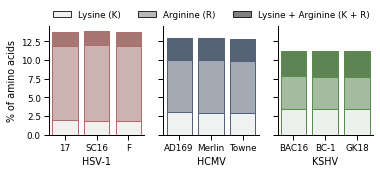

In [19]:
import matplotlib.patches

fig, axs = plt.subplots(ncols=3, figsize = (5.8, 2), sharex=False, sharey=True)

to_plot = pd.concat([ORF_combined[ORF_combined.index.get_level_values('id').str.contains(strain, case=False)].groupby(['virus', 'metric']).mean()*100 for strain in ['strain 17', 'SC16', 'strain F', 'AD169', 'merlin', 'towne', 'BAC16', 'BC1','GK18']], keys = ['17', 'SC16', 'F', 'AD169', 'Merlin', 'Towne', 'BAC16', 'BC-1', 'GK18'], names = ['strain'])

for v, ax, p in zip(['HSV-1', 'HCMV', 'KSHV'], axs, pal):
    sns.barplot(data=to_plot[to_plot.index.get_level_values('virus')==v].reset_index(), 
                x='strain', y=0, hue='metric', 
                dodge=False, 
                hue_order = ['K+R', 'R', 'K'], 
                palette = sns.light_palette(p, 3, reverse=True),
                linewidth=1,
                edgecolor=p,
                ax=ax
               )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_legend().remove()

    ax.set_xlabel(v)
    ax.set_ylabel('')

axs[0].set_ylabel('% of amino acids')
handles = [matplotlib.patches.Patch(facecolor = c, edgecolor='k') for c in sns.light_palette('grey', 3)]
ax.legend(handles, ['Lysine (K)', 'Arginine (R)', 'Lysine + Arginine (K + R)',], 
          bbox_to_anchor=(0, 1.02, 1.05, 0.2), frameon=False, ncol=3)

fig.savefig(r'..\figures\FigS1A.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. S1B

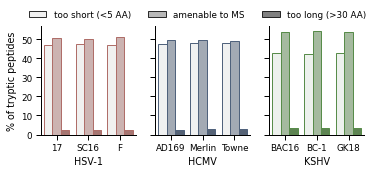

In [23]:
fig, axs = plt.subplots(ncols=3, figsize = (5.8, 2), sharex=False, sharey=True)

to_plot = pd.concat([amenable[amenable.index.get_level_values('id').str.contains(strain, case=False)].groupby(['virus']).mean()*100 for strain in ['strain 17', 'SC16', 'strain F', 'AD169', 'merlin', 'towne', 'BAC16', 'BC1','GK18']], keys = ['17', 'SC16', 'F', 'AD169', 'Merlin', 'Towne', 'BAC16', 'BC-1', 'GK18'], names = ['strain'])

for v, ax, p in zip(['HSV-1', 'HCMV', 'KSHV'], axs, pal):

    sns.barplot(data=to_plot[to_plot.index.get_level_values('virus')==v].stack().reset_index(),
                x = 'strain',y=0, hue='designation', 
                hue_order = ['too short (<5 AA)', 'amenable to MS', 'too long (>30 AA)'], 
                ax=ax,
                palette = sns.light_palette(p, 3),
                linewidth=1,
                edgecolor=p,
               )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_legend().remove()

    ax.set_xlabel(v)
    ax.set_ylabel('')
    

axs[0].set_ylabel('% of tryptic peptides')
handles = [matplotlib.patches.Patch(facecolor = c, edgecolor='k') for c in sns.light_palette('grey', 3)]
ax.legend(handles, ['too short (<5 AA)', 'amenable to MS', 'too long (>30 AA)',], bbox_to_anchor=(0, 1.02, 1.1, 0.2), frameon=False, ncol=3, )

fig.savefig(r'..\figures\FigS1B.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. S1D

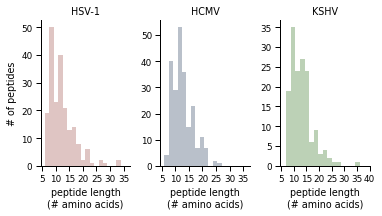

In [11]:
fig, axs = plt.subplots(ncols = 3, figsize = (5.4, 3.1), sharex=True,)

for v,c, ax in zip(['HSV-1','HCMV', 'KSHV'], pal, axs):
    sns.distplot(info['Peptide Length'][v], color=c, ax=ax, kde=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(v, y=1)
    ax.set_xticks([5, 10, 15, 20, 25, 30, 35, 40])

    ax.set_xlabel('peptide length\n(# amino acids)')
axs[0].set_ylabel('# of peptides')
fig.tight_layout()
fig.savefig(r'..\figures\FigS1D.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. S1E

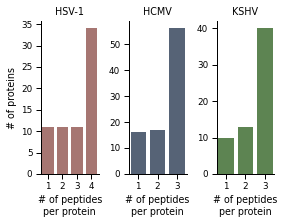

In [12]:
fig, axs = plt.subplots(ncols=3, figsize = (4, 3.2),)

n_pep = info.groupby(['virus', 'Protein Gene', 'Peptide Modified Sequence']).size().groupby(['virus', 'Protein Gene']).size()
to_plot = n_pep.groupby('virus').apply(lambda x: x.groupby(x).size()).reset_index()

for v, ax, p in zip(['HSV-1', 'HCMV', 'KSHV'], axs, pal):
    sns.barplot(data=to_plot[to_plot['virus']==v], x='level_1', y=0, 
                ax=ax, palette=[p]*4
               )
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('# of peptides\nper protein')
    ax.set_ylabel('')
    ax.set_title(v)

axs[0].set_ylabel('# of proteins')

fig.tight_layout()
fig.savefig(r'..\figures\FigS1E.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. S1F

add xticklabels in ppt table

Epithelial cells
Blood & immune cells
Neuronal cells
Vascular cells
Mesenchymal cells

Brain
Bone marrow & lymphoid tissues
Eye
Skin
Blood



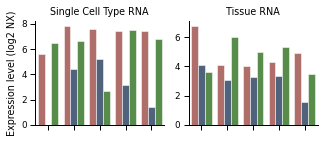

In [18]:
print('add xticklabels in ppt table')
print()

to_plot = expression[expression.index.get_level_values('family/organ').isin(sel)].stack()
to_plot = to_plot.astype(float).apply(np.log2).reset_index()

fig, axs = plt.subplots(ncols=2, figsize = (4.6, 2))

xlabs_1 = ['Epithelial\ncells', 'Blood &\nimmune cells', 'Neuronal\ncells', 'Vascular\ncells', 'Mesenchymal\ncells']
xlabs_2 = ['Brain', 'Bone marrow\n& lymphoid\ntissues', 'Eye', 'Skin', 'Blood']

for (s, data), ax, xlabs in zip(to_plot.groupby('RNA type'), axs, [xlabs_1, xlabs_2]):
    sns.barplot(data=data, x='family/organ', y=0,
                hue_order = ['TUBA1A', 'MYO5A', 'MYH9'],
                hue='Gene', 
                ax=ax, 
                ci=None, 
                palette=pal, 
                saturation=1, 
                edgecolor='white', 
                linewidth=0.5
               )
    ax.set_title(s)
    ax.set_ylabel('')
    ax.set_xlabel('')
    [print(i._text) for i in ax.get_xticklabels()]
    print()
    #ax.set_xticklabels(xlabs, rotation = 90, ha='right', va='top')
    ax.set_xticklabels([])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_legend().remove()

axs[0].set_ylabel('Expression level (log2 NX)')
#ax.legend(frameon=False, bbox_to_anchor=(0, 1.2, 0.5, 0.2), ncol=3)
fig.tight_layout()
fig.savefig(r'..\figures\FigS1F.png', dpi=1000, bbox_inches='tight')
plt.show()